# SI 671 Homework 3
Chenyun Tao  Uniq: cyuntao

## Exploratory Social Network Analysis
1. Load the directed network graph (G) from the file `amazonNetwork.csv`.

In [1]:
import pandas as pd
import networkx as nx
import seaborn as sns
%matplotlib inline

In [2]:
amazonNetwork = pd.read_csv('amazonNetwork.csv')
amazonNetwork.head()

,FromNodeId,ToNodeId
0,1,2
1,1,4
2,1,5
3,1,15
4,2,11


In [3]:
G = nx.from_pandas_edgelist(amazonNetwork, source='FromNodeId',target='ToNodeId', create_using=nx.DiGraph())

2. How many items are present in the network and how many co-purchases happened?

In [4]:
print("Numer of items in the network:", G.number_of_nodes())
print("Number of co-purchases:", G.number_of_edges())

Numer of items in the network: 2647
Number of co-purchases: 10841


3. Compute the average shortest distance between the nodes in graph G. Explain your results briefly.

In [5]:
print("The average shortest distance between the nodes in graph G is:", nx.average_shortest_path_length(G))

The average shortest distance between the nodes in graph G is: 9.592795477759587


In our network, the average shortest distance between the nodes is about 9.59. This means to get from one item to another following the shortest path possible, it must go through 9.59 nodes. This shows that perhaps only some of the items are co-purchased.

4. Compute the transitivity and the average clustering coefficient of the network
graph G. Explain your findings briefly based on the definitions of clustering coefficient and transitivity.

In [6]:
print("The transitivity of the network graph G is:", nx.transitivity(G))

The transitivity of the network graph G is: 0.4339169154480595


In [7]:
print("The average clustering coefficient of the network graph G is:", nx.average_clustering(G))

The average clustering coefficient of the network graph G is: 0.4086089178720651


The transitivity is defined as
$$
T=3 \frac{\# \text { triangles }}{\# \text { triads }}
$$
where triads means two edges with a shared vertex.

The average clustering coefficient is defined as
$$
C=\frac{1}{n} \sum_{u \in G} c_{u} = \frac{1}{n} \sum_{u \in G}\frac{2 T(u)}{\operatorname{deg}(u)(\operatorname{deg}(u)-1)}
$$
where $T(u)$ is the number of triangles through node $u$ and $\operatorname{deg}(u)$ is the degree of $u$.

Therefore, it's unsurprising to see that the transitivity and the average clustering coefficient to be close here.

5. Apply the PageRank algorithm to network G with damping value 0.5 and find the 10 nodes with the highest PageRank. Explain your findings briefly.

In [8]:
pageranks = nx.pagerank(G, alpha=0.5) 
pageranks = {k:v for k, v in sorted(pageranks.items(), key=lambda t: t[1], reverse=True)}

In [9]:
highest_pagerank_nodes = list(pageranks.keys())[0:10]
count = 1
for node in highest_pagerank_nodes:
    print("{}. {}".format(count, node))
    count += 1

1. 8
2. 481
3. 33
4. 18
5. 23
6. 30
7. 346
8. 99
9. 93
10. 21


It seems that the 10 nodes with the highest PageRank values here are the most "important" items in our network. This means that they are most likely to be co-purchased.

In [10]:
set(amazonNetwork.FromNodeId) == set(amazonNetwork.ToNodeId) 

False

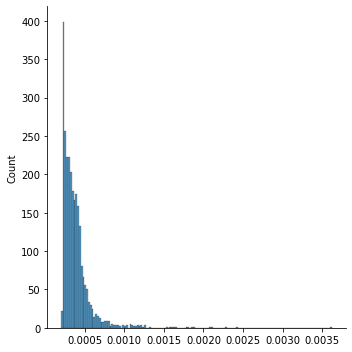

In [11]:
sns.displot(list(pageranks.values()), kde=False)

In addition, it seems that there're a few dead-ends in our data, but there're no spider traps.

## Predicting Review-Rating using Features Derived from Network Properties

In [12]:
review_train = pd.read_csv('reviewTrain.csv')
review_train.head()

,id,title,group,review
0,3,World War II Allied Fighter Planes Trading Cards,Book,5.0
1,5,Prayers That Avail Much for Business: Executive,Book,0.0
2,7,Batik,Music,4.5
3,10,The Edward Said Reader,Book,4.0
4,11,Resetting the Clock : Five Anti-Aging Hormone...,Book,5.0


In [13]:
review_train.id.nunique()  # checking the number of unique items in review_train

1674

In [14]:
len(set(review_train.id) - set(amazonNetwork.FromNodeId).union(set(amazonNetwork.ToNodeId)))

21

This result indicates that missing values exist. 21 ids in `review_train` are not included in the network G in part 1.

After some basic data exploration, I start to select features. I will try a few features as is suggested by the instructions, and then select 5 from these candidates. As we only have a few dead-ends in our data, and no spider traps, I first try to pick page rank as one feature candidate.

In [15]:
pageranks_df = pd.DataFrame.from_dict(pageranks, orient='index', columns=['page_rank'])
pageranks_df.head()

,page_rank
8,0.003625
481,0.002434
33,0.002297
18,0.002103
23,0.002079


In order to utitlize page rank data in training, I need to merge page rank value to the `review_train` dataframe. A few ids in `review_train` are not included in the network G in part 1, so I use left merge, and there will be a few missing values in the `page_rank` column due to the missing ids. I will drop these missing values later.

In [16]:
review_train = review_train.merge(pageranks_df, left_on='id', right_index=True, how='left')
review_train.head()

,id,title,group,review,page_rank
0,3,World War II Allied Fighter Planes Trading Cards,Book,5.0,0.000197
1,5,Prayers That Avail Much for Business: Executive,Book,0.0,0.000774
2,7,Batik,Music,4.5,0.001263
3,10,The Edward Said Reader,Book,4.0,0.000424
4,11,Resetting the Clock : Five Anti-Aging Hormone...,Book,5.0,0.000906


I also try to pick clustering coefficient, degree centrality, closeness centrality, and betweenness centrality as the candidates. The processing procedure is similar, and there will be missing values that need to be dropped.

In [17]:
clustering = nx.clustering(G)
clustering_df = pd.DataFrame.from_dict(clustering, orient='index', columns=['clustering'])
clustering_df.head()

,clustering
1,0.000000
2,0.050000
4,0.188830
5,0.142157
15,0.128743


In [18]:
review_train = review_train.merge(clustering_df, left_on='id', right_index=True, how='left')
review_train.head()

,id,title,group,review,page_rank,clustering
0,3,World War II Allied Fighter Planes Trading Cards,Book,5.0,0.000197,0.450000
1,5,Prayers That Avail Much for Business: Executive,Book,0.0,0.000774,0.142157
2,7,Batik,Music,4.5,0.001263,0.109562
3,10,The Edward Said Reader,Book,4.0,0.000424,0.285714
4,11,Resetting the Clock : Five Anti-Aging Hormone...,Book,5.0,0.000906,0.120344


In [19]:
degree_centrality = nx.degree_centrality(G)
degree_centrality_df = pd.DataFrame.from_dict(degree_centrality, orient='index', columns=['degree_centrality'])
degree_centrality_df.head()

,degree_centrality
1,0.001512
2,0.001890
4,0.007559
5,0.005669
15,0.007181


In [20]:
review_train = review_train.merge(degree_centrality_df, left_on='id', right_index=True, how='left')
review_train.head()

,id,title,group,review,page_rank,clustering,degree_centrality
0,3,World War II Allied Fighter Planes Trading Cards,Book,5.0,0.000197,0.450000,0.001890
1,5,Prayers That Avail Much for Business: Executive,Book,0.0,0.000774,0.142157,0.005669
2,7,Batik,Music,4.5,0.001263,0.109562,0.008692
3,10,The Edward Said Reader,Book,4.0,0.000424,0.285714,0.003779
4,11,Resetting the Clock : Five Anti-Aging Hormone...,Book,5.0,0.000906,0.120344,0.010204


In [21]:
closeness_centrality = nx.closeness_centrality(G)
closeness_centrality_df = pd.DataFrame.from_dict(closeness_centrality, orient='index', columns=['closeness_centrality'])
closeness_centrality_df.head()

,closeness_centrality
1,0.000000
2,0.000378
4,0.065922
5,0.133688
15,0.051976


In [22]:
review_train = review_train.merge(closeness_centrality_df, left_on='id', right_index=True, how='left')
review_train.head()

,id,title,group,review,page_rank,clustering,degree_centrality,closeness_centrality
0,3,World War II Allied Fighter Planes Trading Cards,Book,5.0,0.000197,0.450000,0.001890,0.000000
1,5,Prayers That Avail Much for Business: Executive,Book,0.0,0.000774,0.142157,0.005669,0.133688
2,7,Batik,Music,4.5,0.001263,0.109562,0.008692,0.150353
3,10,The Edward Said Reader,Book,4.0,0.000424,0.285714,0.003779,0.116834
4,11,Resetting the Clock : Five Anti-Aging Hormone...,Book,5.0,0.000906,0.120344,0.010204,0.008231


In [23]:
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_centrality_df = pd.DataFrame.from_dict(betweenness_centrality , orient='index', columns=['between_centrality'])
betweenness_centrality_df.head()

,between_centrality
1,0.000000
2,0.000084
4,0.005049
5,0.004032
15,0.037462


In [24]:
review_train = review_train.merge(betweenness_centrality_df, left_on='id', right_index=True, how='left')
review_train.head()

,id,title,group,review,page_rank,clustering,degree_centrality,closeness_centrality,between_centrality
0,3,World War II Allied Fighter Planes Trading Cards,Book,5.0,0.000197,0.450000,0.001890,0.000000,0.000000
1,5,Prayers That Avail Much for Business: Executive,Book,0.0,0.000774,0.142157,0.005669,0.133688,0.004032
2,7,Batik,Music,4.5,0.001263,0.109562,0.008692,0.150353,0.018768
3,10,The Edward Said Reader,Book,4.0,0.000424,0.285714,0.003779,0.116834,0.003049
4,11,Resetting the Clock : Five Anti-Aging Hormone...,Book,5.0,0.000906,0.120344,0.010204,0.008231,0.008756


As is stated above, missing values are generated when creating the features, so I need to drop these missing values.

In [25]:
review_train.dropna(inplace=True)

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

As groups also seem to be a useful feature, I also pick `group` as a candidate. In addition, since `group` is a categorical feature, I use `LabelEncoder` to encode the `group` column.

In [27]:
groupencoder = LabelEncoder()
review_train['group'] = groupencoder.fit_transform(review_train['group'])

Now I have 6 feature candidates, and I would like to pick 5 from them, so I check the correlation coefficients between these 6 features and `review`. 

In [28]:
review_train.corr()

,id,group,review,page_rank,clustering,degree_centrality,closeness_centrality,between_centrality
id,1.000000,-0.003071,0.033189,-0.356874,0.190649,-0.475670,-0.437823,-0.327841
group,-0.003071,1.000000,0.140767,-0.005651,0.001618,0.001436,0.003376,-0.016622
review,0.033189,0.140767,1.000000,-0.023928,0.023958,-0.024548,-0.015654,-0.002024
page_rank,-0.356874,-0.005651,-0.023928,1.000000,-0.171188,0.888381,0.436432,0.576272
clustering,0.190649,0.001618,0.023958,-0.171188,1.000000,-0.119005,-0.166597,-0.276858
degree_centrality,-0.475670,0.001436,-0.024548,0.888381,-0.119005,1.000000,0.388936,0.528611
closeness_centrality,-0.437823,0.003376,-0.015654,0.436432,-0.166597,0.388936,1.000000,0.381034
between_centrality,-0.327841,-0.016622,-0.002024,0.576272,-0.276858,0.528611,0.381034,1.000000


It seems that actually these features might not be so good as the correlation coefficients are relatively small, but among the 6 features, `group`, `page_rank`, `clustering`, `degree_centrality`, `closeness_centrality` are better, so I pick these 5 features.

In [29]:
# feature matrix consists of the 5 features
train_X = review_train.drop(['review', 'title', 'between_centrality'], axis=1)

In [30]:
# encode review ratings, and this is the target
reviewencoder = LabelEncoder()
train_y = reviewencoder.fit_transform(review_train['review'])

Now I have the preprocessed training data, and I will start on model comparison and selection, and parameter tuning. 

Here I utilize the voting classifier, so that I ensemble the results coming from 5 different classifiers: `KNeighborsClassifier`, `GaussianProcessClassifier`, `DecisionTreeClassifier`, `RandomForestClassifier` and `MLPClassifier`. I also tried `AdaBoostClassifier` and `LogisticRegression`, but these 2 increased MAE, so they're not included in the final voting classifier. 

As I choose to use the above 5 classifiers, I still need to tune the parameters, so that my voting classifier will be ensembled with the 5 classifiers with optimal parameters. I use `GridSeachCV` to perform exhaustive 5-fold cross-validated search to find the best parameters over different parameter values.

In [31]:
# higher MAE, dropped
classifiers = [
    ("Logistic Regression",  LogisticRegression()),
    ("KNN", KNeighborsClassifier()), 
    ("Gaussian Process", GaussianProcessClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()), 
    ("Multi-layer Perceptron", MLPClassifier())
]

grid_bool = [True, False]
grid_solver = ['newton-cg', 'liblinear']
grid_neighbours = [1, 2, 3, 4, 5, 6, 7]
grid_criterion = ['gini', 'entropy']
grid_max_depth = [2, 4, 6, 8, 10, None]
seed = [42]
grid_n_estimator = [5, 10, 15, 20, 25, 30, 40, 50, 100]
grid_alpha = [0.0001, 0.001, 0.01, 1, 10]

In [32]:
grid_param = [
            [{
            # LogisticRegression
            'fit_intercept': grid_bool, 
            'solver': grid_solver,
            'random_state': seed,
            'max_iter': [1000],
             }],
    
            [{
            # KNeighborsClassifier 
            'n_neighbors': grid_neighbours, 
            'weights': ['uniform', 'distance'], 
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
    
            [{    
            # GaussianProcessClassifier
            'max_iter_predict': grid_n_estimator, 
            'random_state': seed
            }],
            
            [{
            # DecisionTreeClassifier
            'criterion': grid_criterion, 
            'max_depth': grid_max_depth, 
            'random_state': seed
             }],
            
            [{
            # RandomForestClassifier
            'n_estimators': grid_n_estimator, 
            'criterion': grid_criterion, 
            'max_depth': grid_max_depth, 
            'random_state': seed
             }],
    
            [{
            # MLPClassifer
            'activation': ['logistic', 'tanh', 'relu'],
            'alpha': grid_alpha,
            'random_state': seed,
            'max_iter': [1000]
            }]
        ]

In [33]:
for clf, param in zip(classifiers, grid_param):  
    best_search = GridSearchCV(estimator=clf[1], param_grid=param, cv=5, scoring='neg_mean_absolute_error')
    best_search.fit(train_X, train_y)

    best_param = best_search.best_params_
    print('The best parameter for {} is {}.'.format(clf[1].__class__.__name__, best_param))
    clf[1].set_params(**best_param) 

C:\Users\tcy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The best parameter for LogisticRegression is {'fit_intercept': False, 'max_iter': 1000, 'random_state': 42, 'solver': 'liblinear'}.


C:\Users\tcy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The best parameter for KNeighborsClassifier is {'algorithm': 'auto', 'n_neighbors': 6, 'weights': 'uniform'}.


C:\Users\tcy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The best parameter for GaussianProcessClassifier is {'max_iter_predict': 5, 'random_state': 42}.


C:\Users\tcy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The best parameter for DecisionTreeClassifier is {'criterion': 'gini', 'max_depth': 8, 'random_state': 42}.


C:\Users\tcy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The best parameter for RandomForestClassifier is {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 15, 'random_state': 42}.


C:\Users\tcy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The best parameter for MLPClassifier is {'activation': 'relu', 'alpha': 0.01, 'max_iter': 1000, 'random_state': 42}.


In [34]:
grid_hard = VotingClassifier(estimators=classifiers, voting='hard')
grid_hard.fit(train_X, train_y)
mae_hard = mean_absolute_error(train_y, grid_hard.predict(train_X))
print("Training MAE by hard voting: %0.2f" % (mae_hard))

grid_soft = VotingClassifier(estimators=classifiers, voting='soft')
grid_soft.fit(train_X, train_y)
mae_soft = mean_absolute_error(train_y, grid_soft.predict(train_X))
print("Training MAE by soft voting: %0.2f" % (mae_soft))

Training MAE by hard voting: 1.85
Training MAE by soft voting: 1.74


In [35]:
# higher MAE, dropped
classifiers = [
    ("KNN", KNeighborsClassifier()), 
    ("Gaussian Process", GaussianProcessClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()), 
    ("Multi-layer Perceptron", MLPClassifier()),
    ("AdaBoost", AdaBoostClassifier())
]

grid_neighbours = [1, 2, 3, 4, 5, 6, 7]
grid_criterion = ['gini', 'entropy']
grid_max_depth = [2, 4, 6, 8, 10, None]
seed = [42]
grid_n_estimator = [5, 10, 15, 20, 25, 30, 40, 50, 100]
grid_alpha = [0.0001, 0.001, 0.01, 1, 10]
grid_learn = [.01, .03, .05, .1, .25]

In [36]:
grid_param = [
            [{
            # KNeighborsClassifier 
            'n_neighbors': grid_neighbours, 
            'weights': ['uniform', 'distance'], 
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
    
            [{    
            # GaussianProcessClassifier
            'max_iter_predict': grid_n_estimator, 
            'random_state': seed
            }],
            
            [{
            # DecisionTreeClassifier
            'criterion': grid_criterion, 
            'max_depth': grid_max_depth, 
            'random_state': seed
             }],
            
            [{
            # RandomForestClassifier
            'n_estimators': grid_n_estimator, 
            'criterion': grid_criterion, 
            'max_depth': grid_max_depth, 
            'random_state': seed
             }],
    
            [{
            # MLPClassifer
            'activation': ['logistic', 'tanh', 'relu'],
            'alpha': grid_alpha,
            'random_state': seed,
            'max_iter': [1000]
            }],
            
            [{
            # AdaBoostClassifier
            'n_estimators': grid_n_estimator, 
            'learning_rate': grid_learn, 
            'random_state': seed
            }]
        ]

In [37]:
for clf, param in zip(classifiers, grid_param):  
    best_search = GridSearchCV(estimator=clf[1], param_grid=param, cv=5, scoring='neg_mean_absolute_error')
    best_search.fit(train_X, train_y)

    best_param = best_search.best_params_
    print('The best parameter for {} is {}.'.format(clf[1].__class__.__name__, best_param))
    clf[1].set_params(**best_param) 

C:\Users\tcy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The best parameter for KNeighborsClassifier is {'algorithm': 'auto', 'n_neighbors': 6, 'weights': 'uniform'}.


C:\Users\tcy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The best parameter for GaussianProcessClassifier is {'max_iter_predict': 5, 'random_state': 42}.


C:\Users\tcy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The best parameter for DecisionTreeClassifier is {'criterion': 'gini', 'max_depth': 8, 'random_state': 42}.


C:\Users\tcy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The best parameter for RandomForestClassifier is {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 15, 'random_state': 42}.


C:\Users\tcy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The best parameter for MLPClassifier is {'activation': 'relu', 'alpha': 0.01, 'max_iter': 1000, 'random_state': 42}.


C:\Users\tcy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The best parameter for AdaBoostClassifier is {'learning_rate': 0.25, 'n_estimators': 50, 'random_state': 42}.


In [38]:
grid_hard = VotingClassifier(estimators=classifiers, voting='hard')
grid_hard.fit(train_X, train_y)
mae_hard = mean_absolute_error(train_y, grid_hard.predict(train_X))
print("Training MAE by hard voting: %0.2f" % (mae_hard))

grid_soft = VotingClassifier(estimators=classifiers, voting='soft')
grid_soft.fit(train_X, train_y)
mae_soft = mean_absolute_error(train_y, grid_soft.predict(train_X))
print("Training MAE by soft voting: %0.2f" % (mae_soft))

Training MAE by hard voting: 1.93
Training MAE by soft voting: 1.68


In [39]:
# Final model
classifiers = [
    ("KNN", KNeighborsClassifier()), 
    ("Gaussian Process", GaussianProcessClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()), 
    ("Multi-layer Perceptron", MLPClassifier())
]

grid_neighbours = [1, 2, 3, 4, 5, 6, 7]
grid_criterion = ['gini', 'entropy']
grid_max_depth = [2, 4, 6, 8, 10, None]
seed = [42]
grid_n_estimator = [5, 10, 15, 20, 25, 30, 40, 50, 100]
grid_alpha = [0.0001, 0.001, 0.01, 1, 10]

In [40]:
grid_param = [
            [{
            # KNeighborsClassifier 
            'n_neighbors': grid_neighbours, 
            'weights': ['uniform', 'distance'], 
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
    
            [{    
            # GaussianProcessClassifier
            'max_iter_predict': grid_n_estimator, 
            'random_state': seed
            }],
            
            [{
            # DecisionTreeClassifier
            'criterion': grid_criterion, 
            'max_depth': grid_max_depth, 
            'random_state': seed
             }],
            
            [{
            # RandomForestClassifier
            'n_estimators': grid_n_estimator, 
            'criterion': grid_criterion, 
            'max_depth': grid_max_depth, 
            'random_state': seed
             }],
    
            [{
            # MLPClassifer
            'activation': ['logistic', 'tanh', 'relu'],
            'alpha': grid_alpha,
            'random_state': seed,
            'max_iter': [1000]
            }]
        ]

In [41]:
for clf, param in zip(classifiers, grid_param):  
    best_search = GridSearchCV(estimator=clf[1], param_grid=param, cv=5, scoring='neg_mean_absolute_error')
    best_search.fit(train_X, train_y)

    best_param = best_search.best_params_
    print('The best parameter for {} is {}.'.format(clf[1].__class__.__name__, best_param))
    clf[1].set_params(**best_param) 

C:\Users\tcy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The best parameter for KNeighborsClassifier is {'algorithm': 'auto', 'n_neighbors': 6, 'weights': 'uniform'}.


C:\Users\tcy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The best parameter for GaussianProcessClassifier is {'max_iter_predict': 5, 'random_state': 42}.


C:\Users\tcy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The best parameter for DecisionTreeClassifier is {'criterion': 'gini', 'max_depth': 8, 'random_state': 42}.


C:\Users\tcy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The best parameter for RandomForestClassifier is {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 15, 'random_state': 42}.


C:\Users\tcy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The best parameter for MLPClassifier is {'activation': 'relu', 'alpha': 0.01, 'max_iter': 1000, 'random_state': 42}.


Now I have selected the components of the voting classifier, and tuned the parameters. I still need to choose from hard voting and soft voting in the voting classifier.

In [42]:
grid_hard = VotingClassifier(estimators=classifiers, voting='hard')
grid_hard.fit(train_X, train_y)
mae_hard = mean_absolute_error(train_y, grid_hard.predict(train_X))
print("Training MAE by hard voting: %0.2f" % (mae_hard))

grid_soft = VotingClassifier(estimators=classifiers, voting='soft')
grid_soft.fit(train_X, train_y)
mae_soft = mean_absolute_error(train_y, grid_soft.predict(train_X))
print("Training MAE by soft voting: %0.2f" % (mae_soft))

Training MAE by hard voting: 1.47
Training MAE by soft voting: 1.67


It seems that hard voting has a lower training MAE, so it is picked as my final model.

In [43]:
review_test = pd.read_csv('reviewTest.csv')
review_test.head()

,id,title,group,review
0,90,The Eagle Has Landed,Book,NaN
1,1372,Che in Africa: Che Guevara's Congo Diary,Book,NaN
2,1382,The Darwin Awards II : Unnatural Selection,Book,NaN
3,253,Celtic Glory,Music,NaN
4,671,Sublte Aromatherapy,Book,NaN


Finally, I use the hard voting classifier to predict the review rating of the Amazon products in `reviewTest.csv`. Some preprocessing is needed to generate the features related to the product ids.

In [44]:
review_test = review_test.merge(pageranks_df, left_on='id', right_index=True, how='left').merge(
    clustering_df, left_on='id', right_index=True, how='left').merge(
    degree_centrality_df, left_on='id', right_index=True, how='left').merge(
    closeness_centrality_df, left_on='id', right_index=True, how='left')
review_test.fillna(0, inplace=True)  # fill in missing values with 0
review_test['group'] = groupencoder.transform(review_test['group'])
review_test.head()

,id,title,group,review,page_rank,clustering,degree_centrality,closeness_centrality
0,90,The Eagle Has Landed,0,0.0,0.000347,0.250000,0.003779,0.116428
1,1372,Che in Africa: Che Guevara's Congo Diary,0,0.0,0.000300,0.288462,0.003023,0.080232
2,1382,The Darwin Awards II : Unnatural Selection,0,0.0,0.000338,0.750000,0.003401,0.063412
3,253,Celtic Glory,2,0.0,0.000268,0.750000,0.002268,0.072458
4,671,Sublte Aromatherapy,0,0.0,0.000358,0.562500,0.003401,0.093620


In [45]:
review_test['review'] = reviewencoder.inverse_transform(grid_hard.predict(
    review_test.drop(['review', 'title'], axis=1)))
review_test['group'] = groupencoder.inverse_transform(review_test['group'])
review_test.head()

,id,title,group,review,page_rank,clustering,degree_centrality,closeness_centrality
0,90,The Eagle Has Landed,Book,0.0,0.000347,0.250000,0.003779,0.116428
1,1372,Che in Africa: Che Guevara's Congo Diary,Book,0.0,0.000300,0.288462,0.003023,0.080232
2,1382,The Darwin Awards II : Unnatural Selection,Book,0.0,0.000338,0.750000,0.003401,0.063412
3,253,Celtic Glory,Music,4.5,0.000268,0.750000,0.002268,0.072458
4,671,Sublte Aromatherapy,Book,0.0,0.000358,0.562500,0.003401,0.093620


The predicted results are shown above, and I save the results as a csv, which will be uploaded on Canvas.

In [46]:
review_test[['id', 'title', 'group', 'review']].to_csv('reviewTestResult.csv', index=False)